## Replace Linear

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.utils.data
import math
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim     # for constructing optimizer
from typing import Optional

from kernels import matmul_triton

class LinearWithBias(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, activation: Optional[str] = None):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(input_dim, output_dim))
        self.bias = nn.Parameter(torch.zeros(output_dim))
        self.activation = activation

    ##@tensor_info('linear')
    def forward(self, x) -> torch.Tensor:
        return matmul_triton(x, self.weight, self.bias, self.activation)   # activation(x * weight + bias)


# 1. preparing the dataset
class GDdataset(Dataset):
    def __init__(self, path):
        self.data = pd.read_csv(path)
        SFR = torch.tensor(self.data.iloc[:, 2:46].values)
        blocks = [SFR[:, i:i+4].reshape(-1, 2, 2) for i in range(0, 45, 5)] # 将36列中的每4列合并成一个2*2矩阵，得到9个块
        
        self.value = torch.cat([torch.cat(blocks[i:i+3], dim=2) for i in range(0, 9, 3)], dim=1) # 将9个块按3*3的方式拼成一个大矩阵
        self.value = self.value.unsqueeze(1).to(torch.float32)
        
        self.target = torch.tensor([1.0 if x == 'OK' else 0.0 for x in self.data.iloc[:, 48].values])
        self.target = self.target.unsqueeze(1)
        
    def __getitem__(self, index):
        return self.value[index], self.target[index]
        
        
    def __len__(self):
        return len(self.data)
    
# 2. define the model
class Net_triton(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层
        # input:(batch_size, 1, 6, 6), output:(batch_size, num_kernels, 3, 3)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4096, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=4096),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1),
        )
        
        # 全连接层
        self.fc = nn.Sequential(
            # nn.Linear(in_features=4096*3*3, out_features=8192),
            LinearWithBias(4096*3*3, 8192, activation='gelu'),
            # nn.ReLU(),
            # nn.Linear(in_features=8192, out_features=4096),
            LinearWithBias(8192, 4096, activation='gelu'),
            # nn.ReLU(),
            nn.Dropout(p=0.5),
            # nn.Linear(in_features=4096, out_features=2048),
            LinearWithBias(4096, 2048, activation='gelu'),
            # nn.ReLU(),
            nn.Dropout(p=0.5),
            # nn.Linear(in_features=2048, out_features=1024),
            LinearWithBias(2048, 1024, activation='gelu'),
            # nn.ReLU(),
            # nn.Linear(in_features=1024, out_features=256),
            LinearWithBias(1024, 256, activation='gelu'),
            # nn.ReLU(),
            # nn.Linear(in_features=256, out_features=1),
            LinearWithBias(256, 1),
        )
        
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.conv(x)
        B = x.shape[0]
        Cin = x.shape[1] * x.shape[2] * x.shape[3]  # 计算出 Cin = 4096 * 3 * 3
        T = 1  # 设置 T = 1，因为不涉及序列长度，这里作为占位符
        x = x.view(B, T, Cin)
        x = self.fc(x)
        x = x.view(x.shape[0], -1)    # (batch_size, 1)
        x = self.sigmoid(x)     
        return x
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层
        # input:(batch_size, 1, 6, 6), output:(batch_size, num_kernels, 3, 3)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4096, kernel_size=2, stride=2),
            nn.BatchNorm2d(num_features=4096),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1),
        )
        
        # 全连接层
        self.fc = nn.Sequential(
            nn.Linear(in_features=4096*3*3, out_features=8192),
            nn.ReLU(),
            nn.Linear(in_features=8192, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=1),
        )
        
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)  # (batch_size, 4096*3*3)
        x = self.fc(x)
        x = x.view(x.shape[0], -1)    # (batch_size, 1)
        x = self.sigmoid(x)     
        return x

batch_size = 128
learning_rate = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

train_dataset = GDdataset("./train_data.csv")
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = GDdataset("./test_data.csv")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)


from torch.utils.tensorboard import SummaryWriter   
tb = SummaryWriter()

model = Net()
model.to(device)

# 3. Construct Loss and Optimizer
loss_function = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr = learning_rate)

# 4. define training cycle
def train(model, epoch):
    model.train()
    total_loss = 0
    total_correct = 0
    for batch_idx, (value, target) in enumerate(train_loader):
        value, target = value.to(device), target.to(device)    # 扔给GPU
        optimizer.zero_grad()
        # forward + backward + update
        output = model(value)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        predicted = (output > 0.5).float()
        total_correct += (predicted == target).sum().item()
        total_loss += loss.item()
        
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] % d%%" % (epoch, len(train_dataset), len(train_loader.dataset), '-' * progress + '>', progress * 2), end="")
        
    # 输出每轮的loss
    # print("\n\n[epoch %d] loss: %.3f train_accuracy: %d / %d=%.3f" % (epoch+1, running_loss, total_correct, len(train_dataset), total_correct / len(train_dataset)))
    
    tb.add_scalar("Loss", total_loss, epoch)              # scalar标量，即添加一个数字
    tb.add_scalar("Number Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", total_correct / len(train_dataset), epoch)
    
def test(model, epoch):
    model.eval()
    with torch.no_grad(): 
        correct = 0         # 分类正确个数
        # total = 0           # 总数
        test_loss = 0
        for value, target in test_loader:
            value, target = value.to(device), target.to(device)    # 扔给GPU
            output = model(value)       # (batch_size, 1)
            predicted = (output > 0.5).float()
            # total += target.size(0)     # 加batch_size
            correct += (predicted == target).sum().item()
            test_loss += loss_function(output, target).item()
            
        test_loss /= len(test_loader.dataset)
        
        print("\nTest: average loss: {:.4f}, test_accuracy: {}/{} ({:.0f}%)".format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        tb.add_scalar("Test_accuracy", correct / len(test_loader.dataset), epoch)

In [ ]:
value, _ = next(iter(train_loader))
model(value.to(device))

In [ ]:
import torch.profiler
from tqdm import tqdm
model = Net().to(device)
# model = torch.compile(model)
# model.load_state_dict(torch.load('model.pt', map_location='cpu'))
model.eval()

profiler = torch.profiler.profile(
    schedule=torch.profiler.schedule(wait=2, warmup=2, active=6, repeat=1),
    on_trace_ready=torch.profiler.tensorboard_trace_handler(dir_name='./performance/'),
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA
    ],
    with_stack=True,
)
profiler.start()
with torch.no_grad():
    for batch_idx in tqdm(range(100), desc='Profiling ...'):
        value, _ = next(iter(train_loader))
        model(value.to(device))
        profiler.step()
profiler.stop()

## Triton-Linear unit test

### single linear

In [2]:
import torch
import torch.nn as nn
from typing import Optional

from kernels.matmul import *

class LinearWithBias(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, activation: Optional[str] = None):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(input_dim, output_dim))
        self.bias = nn.Parameter(torch.zeros(output_dim))
        self.activation = activation

    ##@tensor_info('linear')
    def forward(self, x) -> torch.Tensor:
        return matmul_triton(x, self.weight, self.bias, self.activation)   # activation(x * weight + bias)

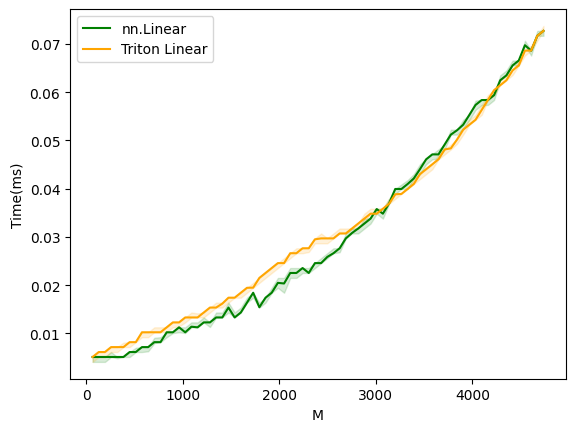

Performance:
         M       N  nn.Linear  Triton Linear
0     64.0    64.0   0.005120       0.005120
1    128.0   128.0   0.005120       0.006144
2    192.0   192.0   0.005120       0.006144
3    256.0   256.0   0.005120       0.007168
4    320.0   320.0   0.005120       0.007168
5    384.0   384.0   0.005120       0.007168
6    448.0   448.0   0.006144       0.008192
7    512.0   512.0   0.006144       0.008192
8    576.0   576.0   0.007168       0.010240
9    640.0   640.0   0.007168       0.010240
10   704.0   704.0   0.008192       0.010240
11   768.0   768.0   0.008192       0.010240
12   832.0   832.0   0.010240       0.011264
13   896.0   896.0   0.010240       0.012288
14   960.0   960.0   0.011264       0.012288
15  1024.0  1024.0   0.010240       0.013312
16  1088.0  1088.0   0.011392       0.013312
17  1152.0  1152.0   0.011264       0.013312
18  1216.0  1216.0   0.012288       0.014336
19  1280.0  1280.0   0.012288       0.015360
20  1344.0  1344.0   0.013312       0.0153

In [7]:
import triton
import triton.language as tl
dtype = torch.float16
device = 'cuda:0'

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["M", "N"],
        x_vals=[64 * i for i in range(1, 75)],
        line_arg='provider',
        line_vals=[
            'torch',
            'triton',
        ],
        line_names=[
            "nn.Linear",
            "Triton Linear",
        ],
        styles=[('green', '-'), ('orange', '-')],
        ylabel="Time(ms)",
        plot_name="Performance",
        # values for function arguments not in `x_names` and `y_name`
        args={'batch_size': 1},
    ))
def benchmark(batch_size, M, N, provider):
    quantiles = [0.5, 0.2, 0.8]

    A = torch.randn((batch_size, M), device=device, dtype=dtype)
    B = A.view(1, batch_size, M)

    if provider == 'torch':
        linear_torch = nn.Linear(M, N).to(device=device, dtype=dtype)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: linear_torch(A), quantiles=quantiles)
    
    elif provider == 'triton':
        linear_triton = LinearWithBias(M, N).to(device=device, dtype=dtype)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: linear_triton(B), quantiles=quantiles)


    return ms, max_ms, min_ms

benchmark.run(
    show_plots=True,
    print_data=True,
)


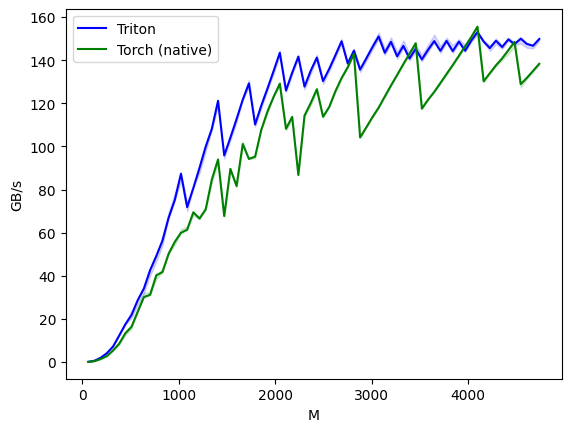

Performance:
         M       N       K      Triton  Torch (native)
0     64.0    64.0    64.0    0.102400        0.051200
1    128.0   128.0   128.0    0.605413        0.414785
2    192.0   192.0   192.0    1.974857        1.382400
3    256.0   256.0   256.0    4.096000        2.730667
4    320.0   320.0   320.0    7.160839        5.333333
5    384.0   384.0   384.0   12.288000        8.507077
6    448.0   448.0   448.0   17.561600       13.380267
7    512.0   512.0   512.0   21.845333       16.384000
8    576.0   576.0   576.0   28.711385       23.328000
9    640.0   640.0   640.0   34.133334       30.117647
10   704.0   704.0   704.0   42.592000       31.153007
11   768.0   768.0   768.0   49.151998       40.215272
12   832.0   832.0   832.0   56.243201       41.709905
13   896.0   896.0   896.0   66.901334       50.175999
14   960.0   960.0   960.0   75.130433       55.741936
15  1024.0  1024.0  1024.0   87.381330       59.918627
16  1088.0  1088.0  1088.0   71.870170       61.3525

In [4]:
import torch
import triton
import triton.language as tl
from typing import Optional
from kernels import *

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["M", "N", "K"],
        x_vals=[64*i for i in range(1, 75)],
        line_arg='provider',
        line_vals=[
            'triton',
            'torch',
        ],
        line_names=[
            "Triton",
            "Torch (native)",
        ],
        styles=[('blue', '-'), ('green', '-')],
        ylabel="GB/s",
        plot_name="Performance",
        # values for function arguments not in `x_names` and `y_name`
        args={'batch_size': 1},
    ))
def benchmark(batch_size, M, N, K, provider):
    quantiles = [0.5, 0.2, 0.8]

    A = torch.randn((batch_size, M, K), device='cuda', dtype=dtype)
    B = torch.randn((K, N), device='cuda', dtype=dtype)
    bias = torch.randn((N), device='cuda', dtype=dtype)

    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul_triton(A, B, bias, "gelu"), quantiles=quantiles)
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.nn.functional.gelu(torch.matmul(A, B) + bias), quantiles=quantiles)

    def gbps(ms): return 2 * batch_size * M * N * K * 1e-12 / (ms * 1e-3)

    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(
    show_plots=True,
    print_data=True,
)

### fc

In [5]:
import torch
import torch.nn as nn
from typing import Optional
from kernels.matmul import *
device = 'cuda'

class LinearWithBias(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, activation: Optional[str] = None):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(input_dim, output_dim))
        self.bias = nn.Parameter(torch.zeros(output_dim))
        self.activation = activation

    ##@tensor_info('linear')
    def forward(self, x) -> torch.Tensor:
        return matmul_triton(x, self.weight, self.bias, self.activation)   # activation(x * weight + bias)

class TorchLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(in_features, out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

    ##@tensor_info('linear')
    def forward(self, x) -> torch.Tensor:
        return torch.matmul(x, self.weight) + self.bias
# fc_torch = nn.Sequential(
#             nn.Linear(in_features=16*3*3, out_features=256),
#             nn.GELU(),
#             nn.Linear(in_features=256, out_features=64),
#             nn.GELU(),
#             # nn.Dropout(p=0.5),
#             nn.Linear(in_features=64, out_features=16),
#             nn.GELU(),
#             # nn.Dropout(p=0.5),
#             nn.Linear(in_features=16, out_features=1),).to(device)
fc_torch = nn.Sequential(
            TorchLinear(in_features=16*3*3, out_features=256),
            nn.GELU(),
            TorchLinear(in_features=256, out_features=64),
            nn.GELU(),
            # nn.Dropout(p=0.5),
            TorchLinear(in_features=64, out_features=16),
            nn.GELU(),
            # nn.Dropout(p=0.5),
            TorchLinear(in_features=16, out_features=1),).to(device)

fc_triton = nn.Sequential(
            LinearWithBias(16*3*3, 256, activation='gelu'),
            LinearWithBias(256, 64, activation='gelu'),
            # nn.Dropout(p=0.5),
            LinearWithBias(64, 16, activation='gelu'),
            # nn.Dropout(p=0.5),
            LinearWithBias(16, 1),).to(device)

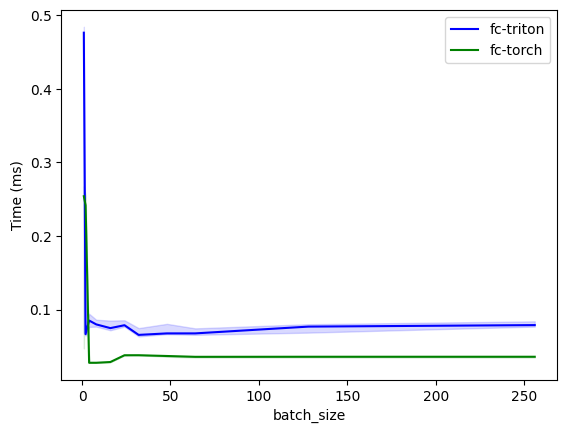

benchmark_vit:
    batch_size  fc-triton  fc-torch
0          1.0   0.476160  0.253952
1          2.0   0.066560  0.241664
2          4.0   0.085056  0.027648
3          8.0   0.079824  0.027648
4         16.0   0.074752  0.028672
5         24.0   0.078688  0.037888
6         32.0   0.065536  0.037888
7         48.0   0.067584  0.036864
8         64.0   0.067584  0.035744
9        128.0   0.076800  0.035840
10       256.0   0.078848  0.035840


In [6]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['batch_size'],
        x_vals=[1, 2, 4, 8, 16, 24, 32, 48, 64, 128, 256],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['fc-triton', 'fc-torch'],
        styles=[('blue', '-'), ('green', '-')],
        ylabel='Time (ms)',
        plot_name='benchmark_vit',
        args={'model1': fc_triton, 'model2': fc_torch}
    )
)
def benchmark(batch_size, model1, model2, provider):
    quantiles = [0.5, 0.2, 0.8]
    inp = torch.randn((batch_size, 16*3*3), device=device)
    inp_triton = inp.view(1, batch_size, 16*3*3)

    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: model1(inp_triton), quantiles=quantiles) 
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: model2(inp), quantiles=quantiles)
    
    return ms, min_ms, max_ms

benchmark.run(
    show_plots=True,
    print_data=True,
)

## Quantized Matmul

In [1]:
import time
import torch

import triton
import triton.language as tl


@triton.autotune(
    configs=[
        triton.Config({}, num_stages=2, num_warps=8),
        triton.Config({}, num_stages=2, num_warps=4),
        triton.Config({}, num_stages=2, num_warps=2),
        triton.Config({}, num_stages=2, num_warps=1),
     ],
    key=['K'],
)
@triton.jit
def quantize_int8_perrow_kernel(
    fpa_ptr, a_ptr, as_ptr,
    M, K, 
    stride_fpam, stride_fpak,
    stride_am, stride_ak,
    stride_asm,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
):
    pid_m = tl.program_id(axis=0)
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M

    fpa_ptrs = fpa_ptr + offs_am[:, None] * stride_fpam + offs_k[None, :] * stride_fpak
    a_ptrs = a_ptr + offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak
    a_max = tl.zeros((BLOCK_SIZE_M,), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        fpa = tl.load(fpa_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        a_max = tl.maximum(a_max, tl.max(tl.abs(fpa), axis=1))
        fpa_ptrs += BLOCK_SIZE_K * stride_fpak
    a_scale = (a_max / 127.)
    fpa_ptrs = fpa_ptr + offs_am[:, None] * stride_fpam + offs_k[None, :] * stride_fpak
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        fpa = tl.load(fpa_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        inta = (fpa / a_scale[:, None]).to(tl.int8)
        tl.store(a_ptrs, inta, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K)
        fpa_ptrs += BLOCK_SIZE_K * stride_fpak
        a_ptrs += BLOCK_SIZE_K * stride_ak
    as_offs = pid_m * BLOCK_SIZE_M * stride_asm + tl.arange(0, BLOCK_SIZE_M)
    tl.store(as_ptr + as_offs, a_scale)


def quantize_int8_perrow(fpa):
    a = torch.empty(fpa.shape, device=fpa.device, dtype=torch.int8)
    a_scale = torch.empty(fpa.shape[0], device=fpa.device, dtype=fpa.dtype)
    M, K = fpa.shape
    BLOCK_SIZE_M = 1
    BLOCK_SIZE_K = triton.next_power_of_2(K)
    grid = (M // BLOCK_SIZE_M,)
    quantize_int8_perrow_kernel[grid](
        fpa, a, a_scale,
        M, K,
        fpa.stride(0), fpa.stride(1),
        a.stride(0), a.stride(1),
        a_scale.stride(0),
        BLOCK_SIZE_M, BLOCK_SIZE_K,
    )
    return a, a_scale


@triton.autotune(
    configs=[
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
	    triton.Config({'SPLIT_K': 1, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 32,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32,  'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64,  'GROUP_SIZE_M': 16}, num_stages=4, num_warps=4),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 16}, num_stages=3, num_warps=8),
		triton.Config({'SPLIT_K': 2, 'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 256, 'GROUP_SIZE_M': 16}, num_stages=2, num_warps=4),
    ],
    key=['M', 'N', 'K'],
    reset_to_zero=['c_ptr']
)
@triton.jit
def matmul_kernel(
    # Pointers to matrices
    a_ptr, as_ptr, b_ptr, bs_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,
    stride_asm,
    stride_bk, stride_bn,
    stride_bsn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr, SPLIT_K: tl.constexpr, 
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    pid_sp_k = tl.program_id(axis=1)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetics` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = pid_sp_k * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)
    as_ptrs = as_ptr + offs_am * stride_asm
    bs_ptrs = bs_ptr + offs_bn * stride_bsn
    a_scale = tl.load(as_ptrs, mask=offs_am < M, other=0.0)
    b_scale = tl.load(bs_ptrs, mask=offs_bn < N, other=0.0)
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.int32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K * SPLIT_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    c = (accumulator.to(tl.float32) * a_scale[:, None] * b_scale[None, :]).to(c_ptr.dtype.element_ty)   
    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    if SPLIT_K == 1:
        tl.store(c_ptrs, c, mask=c_mask)
    else:
        tl.atomic_add(c_ptrs, c, mask=c_mask)


def matmul_quantize_int8(fpa, b, b_scale, out=None):
    a, a_scale = quantize_int8_perrow(fpa)
    # a, a_scale = quantize_int8(fpa, axis=1)
    return matmul_int8(a, a_scale, b, b_scale, out)


def matmul_int8(a, a_scale, b, b_scale, out=None):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    if out == None:
        c = torch.zeros((M, N), device=a.device, dtype=torch.float16)
    else:
        c = out.fill_(0.)
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
        META['SPLIT_K'],
    )
    matmul_kernel[grid](
        a, a_scale, b, b_scale, c,
        M, N, K,
        a.stride(0), a.stride(1),
        a_scale.stride(0),
        b.stride(0), b.stride(1),
        b_scale.stride(0),
        c.stride(0), c.stride(1),
    )
    return c


def quantize_int8(weight, axis=0, tp_rank=0):
    # Weight shape: [H1, H2]
    # Scale shape: [H2]
    scale = weight.abs().amax(axis, keepdim=True) / 127.
    weight = (weight / scale).to(torch.int8)
    # col major will accelerate i8xi8 kernel.
    if axis == 0:
        weight = weight.t().contiguous().t()
    scale = scale.squeeze(axis)
    return weight.contiguous().cuda(tp_rank), scale.contiguous().cuda(tp_rank)


def test_correct_int8(M=32, N=4096, K=4096):
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16)
    int_a, scale_a = quantize_int8_perrow(a)
    cos = torch.nn.CosineSimilarity(0)
    print("Quantization cos", cos((int_a * scale_a.unsqueeze(1)).flatten().to(torch.float32), a.flatten().to(torch.float32)))
    int_b, scale_b = quantize_int8(b, axis=0)
    triton_output = matmul_int8(int_a, scale_a, int_b, scale_b)
    torch_output = torch.matmul(a, b)
    print(f"triton_output={triton_output}")
    print(f"torch_output={torch_output}")
    cos = torch.nn.CosineSimilarity(0)
    print("Output cos", cos(triton_output.flatten().to(torch.float32), torch_output.flatten().to(torch.float32)))


def test_int8(M, K, N):
    import time

    print("M: {} K: {} N: {}".format(M, K, N))
    torch.manual_seed(0)
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16).contiguous()
    int_b, scale_b = quantize_int8(b, axis=0)
    for _ in range(10):
        # int_a, a_scale = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
        triton_output = matmul_int8(int_a, a_scale, int_b, scale_b)
    torch.cuda.synchronize()
    iters = 512
    t1 = time.time()
    for _ in range(iters):
        #int_a, a_scale, _ = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
    torch.cuda.synchronize()
    qt2 = time.time()
    for _ in range(iters):
        triton_output = matmul_int8(int_a, a_scale, int_b, scale_b)
    torch.cuda.synchronize()
    t2 = time.time()
    quant_time = qt2 - t1
    triton_time = t2 - qt2
    triton_tflops = 2 * M * N * K * 1e-12 / (triton_time / iters)
    quant_bandwith = 2 * M * K * 1e-9 / (quant_time / iters)
    print("Triton time cost: {} (tflops {}) + quant: {} (bandwidth {})".format(
        triton_time, triton_tflops, quant_time, quant_bandwith))
    for _ in range(10):
        torch_output = torch.matmul(a, b)
    torch.cuda.synchronize()
    iters = 512
    t1 = time.time()
    for _ in range(iters):
        torch_output = torch.matmul(a, b)
    torch.cuda.synchronize()
    t2 = time.time()
    torch_time = t2 - t1
    torch_tflops = 2 * M * N * K * 1e-12 / (torch_time / iters)
    print("Torch time cost: {} (tflops {})".format(t2 - t1, torch_tflops))
    return triton_time, torch_time, quant_time

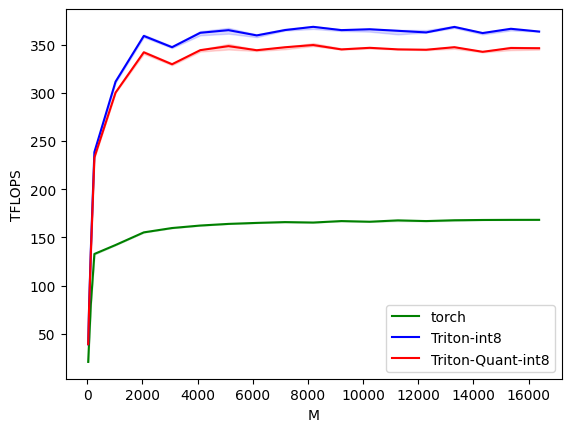

matmul-performance:
          M       torch  Triton-int8  Triton-Quant-int8
0      32.0   20.771184    39.131428          39.131428
1      64.0   41.346415    78.262856          76.889823
2     128.0   80.787468   138.038418         133.951320
3     256.0  132.809696   238.515376         232.944320
4    1024.0  142.114505   311.660094         300.314857
5    2048.0  155.226384   359.147345         342.157219
6    3072.0  159.734668   347.432792         329.734406
7    4096.0  162.328835   362.395445         344.375800
8    5120.0  164.031618   365.131589         348.558920
9    6144.0  165.061242   359.682252         344.305338
10   7168.0  165.888695   365.222430         347.391807
11   8192.0  165.434433   368.586189         349.695555
12   9216.0  166.960766   365.173846         345.146780
13  10240.0  166.267984   366.084671         346.802764
14  11264.0  167.686675   364.454160         345.194511
15  12288.0  166.944205   362.786036         344.799105
16  13312.0  167.805937   36

In [11]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M'],  # Argument names to use as an x-axis for the plot
        x_vals=[32, 64, 128, 256] + [
            512 * i * 2 for i in range(1, 17)
        ],  # Different possible values for `x_name`
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=['torch', 'triton-int8', 'triton-quant-int8'],
        # Label name for the lines
        line_names=["torch", "Triton-int8", "Triton-Quant-int8"],
        # Line styles
        styles=[('green', '-'), ('blue', '-'), ('red', '-')],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    )
)
def benchmark(M, provider):
    K = 10240
    N = 27392 * 2 // 8
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        a = torch.randn((M, K), device='cuda', dtype=torch.float16)
        b = torch.randn((K, N), device='cuda', dtype=torch.float16)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
        perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    if provider == 'triton-int8':
        a = torch.randn((M, K), device='cuda', dtype=torch.float16).to(torch.int8).contiguous()
        b = torch.randn((K, N), device='cuda', dtype=torch.float16).to(torch.int8).contiguous()
        int_a, a_scale = quantize_int8(a, axis=1)
        int_b, b_scale = quantize_int8(b, axis=0)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul_int8(int_a, a_scale, int_b, b_scale), quantiles=quantiles)
        perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    if provider == 'triton-quant-int8':
        a = torch.randn((M, K), device='cuda', dtype=torch.float16).to(torch.int8).contiguous()
        b = torch.randn((K, N), device='cuda', dtype=torch.float16).to(torch.int8).contiguous()
        int_b, b_scale = quantize_int8(b, axis=0)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul_quantize_int8(a, int_b, b_scale), quantiles=quantiles)
        perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(min_ms), perf(max_ms)
benchmark.run(show_plots=True, print_data=True)

In [7]:
import torch

# 定义测试矩阵
fpa = torch.tensor([
    [0.5, -1.2, 3.0, 4.1],
    [-0.7, 0.3, -2.5, 1.6],
    [3.5, -1.1, 0.5, -4.0]
], dtype=torch.float32).cuda()

# 调用量化函数
a, a_scale = quantize_int8_perrow(fpa)

# 输出量化后的矩阵和缩放因子
print("Quantized Matrix (int8):")
print(a)
print("Scale Factors (per row):")
print(a_scale)

Quantized Matrix (int8):
tensor([[  15,  -37,   92,  127],
        [ -35,   15, -127,   81],
        [ 111,  -34,   15, -127]], device='cuda:0', dtype=torch.int8)
Scale Factors (per row):
tensor([0.0323, 0.0197, 0.0315], device='cuda:0')


## Add

In [1]:
import torch
import torch.nn as nn
import triton
import triton.language as tl
from kernels.add import *

device = 'cuda'
dtype = torch.float16

A = torch.randn((2, 2000, 5000), dtype=dtype, device=device)
B = torch.randn((2, 2000, 5000), dtype=dtype, device=device)

y_torch = torch.add(A, B)
y_triton = add_triton(A, B)

print(f'Original matrix:\n{A}\n{B}')
print(f'PyTorch patching:\n{y_torch}')
print(f'Triton patching:\n{y_triton}')

if torch.allclose(y_torch, y_triton):
    print('Data matches')

else:
    print('Data does not match')

Original matrix:
tensor([[[ 0.4175, -1.0928, -0.3000,  ..., -1.3252, -1.0596,  1.2275],
         [-0.2859,  0.6982,  0.3188,  ..., -0.4424,  0.5117, -1.3271],
         [-1.7773,  2.4863, -0.9844,  ...,  0.6270,  0.6636, -0.0161],
         ...,
         [ 0.0390, -1.8174,  1.0557,  ..., -1.0410,  0.3728,  1.6172],
         [ 0.7822,  0.4563,  1.9502,  ...,  0.0670,  1.0156,  1.0508],
         [ 0.2964,  2.8613, -1.5410,  ...,  1.5479, -0.2830, -1.3672]],

        [[-1.4326,  0.1874, -0.3176,  ...,  0.3806,  0.1687,  2.3809],
         [-1.1328, -0.4089,  1.2256,  ..., -0.3071, -0.8970, -0.1747],
         [ 0.1776,  0.4900, -1.6572,  ..., -0.7363, -1.6367,  0.6001],
         ...,
         [-1.2188, -0.3552,  0.5562,  ..., -0.5845,  0.0197,  0.3103],
         [-0.2505, -0.3870, -0.1426,  ...,  1.1514,  1.2363,  1.2188],
         [ 0.7422, -0.3193, -1.8535,  ...,  0.7148,  0.7510,  2.0566]]],
       device='cuda:0', dtype=torch.float16)
tensor([[[-1.4697, -0.6270,  0.5015,  ...,  0.1321, -0

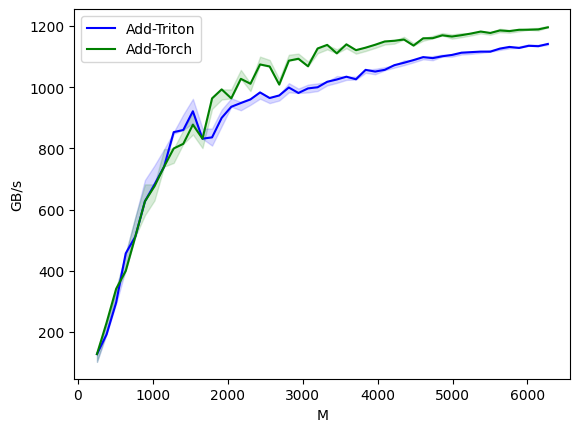

Performance:
         M       N   Add-Triton    Add-Torch
0    256.0   256.0   128.000000   128.000000
1    384.0   384.0   191.999993   230.400006
2    512.0   512.0   296.542993   341.333321
3    640.0   640.0   457.142851   400.000001
4    768.0   768.0   511.999982   511.999982
5    896.0   896.0   627.200016   627.200016
6   1024.0  1024.0   682.666643   676.500677
7   1152.0  1152.0   740.571418   740.571418
8   1280.0  1280.0   853.333355   800.000002
9   1408.0  1408.0   860.444414   815.157931
10  1536.0  1536.0   921.600023   877.714293
11  1664.0  1664.0   832.000009   832.000009
12  1792.0  1792.0   836.266688   963.764708
13  1920.0  1920.0   900.000002   993.103424
14  2048.0  2048.0   936.228546   963.764689
15  2176.0  2176.0   948.512853  1027.555519
16  2304.0  2304.0   960.277826  1011.512212
17  2432.0  2432.0   983.148908  1074.604651
18  2560.0  2560.0   964.899878  1068.057339
19  2688.0  2688.0   973.241355  1008.844449
20  2816.0  2816.0   999.225820  1086.8771

In [1]:
import torch
import torch.nn as nn
import triton
import triton.language as tl
from kernels.add import *

device = 'cuda'
dtype = torch.float16
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N'],  # argument names to use as an x-axis for the plot
        # different possible values for `x_name`
        x_vals=[128*i for i in range(2, 50)],
        # argument name whose value corresponds to a different line in the plot
        line_arg='provider',
        line_vals=[
            'triton',
            'torch',
        ],
        line_names=[
            "Add-Triton",
            "Add-Torch",
        ],
        styles=[('blue', '-'), ('green', '-')],
        ylabel="GB/s",
        plot_name="Performance",
        args={'B': 1},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(B, M, N, provider):
    x = torch.randn(B, M, N, device='cuda', dtype=dtype)
    y = torch.randn(B, M, N, device='cuda', dtype=dtype)

    quantiles = [0.5, 0.2, 0.8]

    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: add_triton(x, y), quantiles=quantiles)
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.add(x, y), quantiles=quantiles)

    def gbps(ms): return B * 2 * (x.nelement() + y.nelement()) * x.element_size() * 1e-9 / (ms * 1e-3)

    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(
    show_plots=True, # weirdly show_plots and save_paths don't work together
    print_data=True,
)

## Transpose2D

In [5]:
import torch
import torch.nn as nn
import triton
import triton.language as tl
from kernels.transpose import *

device = 'cuda'
dtype = torch.float16

X = torch.randn((3, 4), dtype=dtype, device=device)

y_torch = torch.transpose(X, 0, 1)
y_triton = triton_transpose(X)

print(f'Original matrix:\n{X}')
print(f'PyTorch:\n{y_torch}')
print(f'Triton:\n{y_triton}')

if torch.allclose(y_torch, y_triton):
    print('Data matches')

else:
    print('Data does not match')

Original matrix:
tensor([[-0.4961,  1.4189,  1.0693,  0.6274],
        [ 0.7988, -0.1908,  0.8174,  0.1948],
        [ 0.2859, -2.3516,  0.1545, -0.1177]], device='cuda:0',
       dtype=torch.float16)
PyTorch:
tensor([[-0.4961,  0.7988,  0.2859],
        [ 1.4189, -0.1908, -2.3516],
        [ 1.0693,  0.8174,  0.1545],
        [ 0.6274,  0.1948, -0.1177]], device='cuda:0', dtype=torch.float16)
Triton:
tensor([[-0.4961,  0.7988,  0.2859],
        [ 1.4189, -0.1908, -2.3516],
        [ 1.0693,  0.8174,  0.1545],
        [ 0.6274,  0.1948, -0.1177]], device='cuda:0', dtype=torch.float16)
Data matches


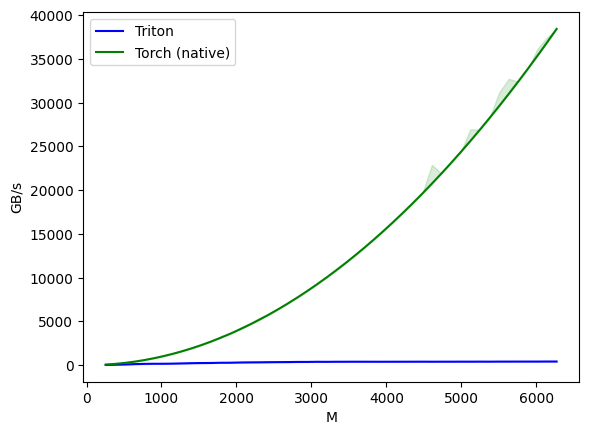

Performance:
         M       N      Triton  Torch (native)
0    256.0   256.0   25.600001       64.000000
1    384.0   384.0   47.999998      144.000000
2    512.0   512.0   75.502306      256.000001
3    640.0   640.0  116.099778      400.000001
4    768.0   768.0  144.000000      576.000001
5    896.0   896.0  156.800004      784.000002
6   1024.0  1024.0  157.538463     1024.000003
7   1152.0  1152.0  172.800004     1296.000003
8   1280.0  1280.0  200.000001     1600.000004
9   1408.0  1408.0  227.764702     1936.000005
10  1536.0  1536.0  242.526327     2304.000006
11  1664.0  1664.0  247.222866     2704.000007
12  1792.0  1792.0  272.695646     3136.000008
13  1920.0  1920.0  276.923080     3600.000009
14  2048.0  2048.0  303.407407     4096.000010
15  2176.0  2176.0  318.210759     4624.000012
16  2304.0  2304.0  324.000001     5184.000013
17  2432.0  2432.0  339.764700     5776.000015
18  2560.0  2560.0  346.238364     6400.000016
19  2688.0  2688.0  352.800009     7056.000018


In [7]:
import torch
import torch.nn as nn
import triton
import triton.language as tl
from kernels.transpose import *

device = 'cuda'
dtype = torch.float16
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N'],  # argument names to use as an x-axis for the plot
        # different possible values for `x_name`
        x_vals=[128*i for i in range(2, 50)],
        # argument name whose value corresponds to a different line in the plot
        line_arg='provider',
        line_vals=[
            'triton',
            'torch',
        ],
        line_names=[
            "Triton",
            "Torch (native)",
        ],
        styles=[('blue', '-'), ('green', '-')],
        ylabel="GB/s",
        plot_name="Performance",
        args={},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=dtype)

    quantiles = [0.5, 0.2, 0.8]

    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: triton_transpose(x), quantiles=quantiles)
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.transpose(x, 0, 1), quantiles=quantiles)

    def gbps(ms): return x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)

    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(
    show_plots=True, # weirdly show_plots and save_paths don't work together
    print_data=True,
)

## QuantLinear